In [48]:
import numpy as np
from TDD.TDD import TDD, Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2,Slicing
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit,qasm2
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx
import copy
from qiskit.circuit.library.standard_gates import HGate,U1Gate,U3Gate
from qiskit.quantum_info.operators import Operator

to_test = True

In [4]:
def simulate(cir,ini=False):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
#     A=[ts.name for ts in tn.tensors]
#     print(A)
    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
        for n in range(10):
            for k in range(50):
                s ='x'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)
                s ='y'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)               
                
        
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)

#     t_start=time.time()
    tdd=tn.cont()
#     print(time.time()-t_start)
#     print(tdd.weight)
#     print(tdd.node_number())
    return tdd

def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
#     cir_head.x([0,1,2])
#     cir_head.x([0,1,2])
#     cir_end.x([0,1,2])
#     cir_end.x([0,1,2])
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd,tdd1)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    # tdd_new=renormalize(tdd_new)
    return tdd_new

def get_downward_k_level_map(tdd,k,c):
    if k==0:
        if c==0:
            return tdd.node.out_maps[1],tdd.node.out_weight[1]
        else:
            return tdd.node.successor[0].out_maps[1],tdd.node.successor[0].out_weight[1]
    temp_tdd = Slicing2(Slicing2(tdd,tdd.node.key,0),tdd.node.key-1,0)
    return get_downward_k_level_map(temp_tdd,k-1,c)

In [5]:
def get_dependency_cycle(node,G=None,node_2_succ_nodes=None,node_2_key=None,key_num=None,reduced=False):
    if isinstance(node, TDD):
        node = node.node
    if G==None:
        G = nx.Graph()
    if node_2_succ_nodes==None:
        node_2_succ_nodes = {}
    if node_2_key==None:
        node_2_key = {}
    if key_num==None:
        key_num = {}

    if node.key ==-1:
        node_2_succ_nodes[node]=[node]
        return G


    if node in node_2_succ_nodes:
        return G
    
    # if node.key==0:
    #     G.add_node(node,label=node.key)
    #     node_2_succ_nodes[node]=[node]
    #     return G,node_2_succ_nodes
    
    G = get_dependency_cycle(node.successor[0],G,node_2_succ_nodes,node_2_key,key_num)
    G = get_dependency_cycle(node.successor[1],G,node_2_succ_nodes,node_2_key,key_num)
    
    
    if not node.key in key_num:
        key_num[node.key]=0
        node_2_key[node]=node.key
    else:
        key_num[node.key]+=1
        node_2_key[node]=str(node.key)+'_'+str(key_num[node.key])
        
    G.add_node(node_2_key[node],label=node.key)
    node_2_succ_nodes[node]=[node]+node_2_succ_nodes[node.successor[0]]
    for node1 in node_2_succ_nodes[node.successor[1]]:
        if not node1 in node_2_succ_nodes[node]:
            node_2_succ_nodes[node].append(node1)
            

    
    the_map1 = node.out_maps[1]
    
    while the_map1.level>-1:
        for node1 in node_2_succ_nodes[node.successor[1]]:
            if node1.key==the_map1.level:
                # G.add_edge([node, node1,map={'x': the_map1.x, 'rotate': the_map1.rotate})
                G.add_edge(node_2_key[node], node_2_key[node1],map={'x': the_map1.x, 'rotate': the_map1.rotate})
        the_map1=the_map1.father
    
    if node.key%2==1:
        U=np.array([[1,1],[node.successor[0].out_weight[1],node.successor[1].out_weight[1]]],dtype=complex)
        if node.out_maps[1].level==node.key-1:
            if node.out_maps[1].rotate>0:
                U[1][1]=U[1][1]*np.exp(1j*np.pi/4*(node.out_maps[1].rotate))
            if node.out_maps[1].x==1:
                U[0][1],U[1][1]=U[1][1],U[0][1]      
        # G.add_edge(node, node.successor[1])
        # G.add_edge(node, node.successor[0],map={'u':U})
        G.add_edge(node_2_key[node], node_2_key[node.successor[1]])
        G.add_edge(node_2_key[node], node_2_key[node.successor[0]],map={'u':U})    


    # if node.successor[0]!=node.successor[1]:
    #     G.add_edge(node_2_key[node.successor[0]], node_2_key[node.successor[1]])
    
    return G

def reduce_graph(G):
    nodes = list(G.nodes())
    flag = True
    while flag:
        flag = False
        for node in nodes:
            A = list(G.neighbors(node))
            if len(A)==1:
                if isinstance(node,str):
                    a=int(node.split('_')[0])
                else:
                    a = node
                if str(a)+'_1' in nodes:
                    continue
                G.remove_node(node)
                G.remove_node(A[0])
                nodes.remove(node)
                nodes.remove(A[0])
                flag = True
    return G

# def get_dependency_cycle(node,G=None):
#     if isinstance(node, TDD):
#         node = node.node
#     if G==None:
#         G = nx.Graph()

#     if node.key ==-1:
#         return G

#     G = get_dependency_cycle(node.successor[0])
#     G.add_node(node.key,label=node.key)
    
#     the_map1 = node.out_maps[1]
    
#     while the_map1.level>-1:
#         G.add_edge(node.key, the_map1.level,map={'x': the_map1.x, 'rotate': the_map1.rotate})
#         the_map1=the_map1.father
    
#     if node.key%2==1:
#         U=np.array([[1,1],[node.successor[0].out_weight[1],node.successor[1].out_weight[1]]],dtype=complex)
#         if node.out_maps[1].level==node.key-1:
#             if node.out_maps[1].rotate>0:
#                 U[1][1]=U[1][1]*np.exp(1j*np.pi/4*(node.out_maps[1].rotate))
#             if node.out_maps[1].x==1:
#                 U[0][1],U[1][1]=U[1][1],U[0][1]
#         G.add_edge(node.key, node.key-1,map={'u':U})
        
#     if node.successor[0]!=node.successor[1]:
#         node0 = node.successor[0]
#         node1 = node.successor[1]
#         if TDD(node0).node_number() == node.key+1 and TDD(node1).node_number() == node.key+1:
#             for k in range(node.key-1,-1,-1):
#                 if node0.out_maps[1]!=node1.out_maps[1]:
#                     the_map2,the_phase = node0.out_maps[1]/node1.out_maps[1]
#                     while the_map2.level>-1:
#                         G.add_edge(node.key, k,map={'x2': [the_map2.level,the_map2.x], 'rotate2': [the_map2.level,the_map2.rotate]})
#                         G.add_edge(node.key,the_map2.level,map={})
#                         G.add_edge(k,the_map2.level,map={})
#                         the_map2=the_map2.father

#                 a=node0.out_weight[1]
#                 b=node1.out_weight[1]
#                 if a!=b:
#                     theta = float(np.arctan((a-b)/(1+a*b)))
#                     U = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
#                     G.add_edge(node.key, k,map={'u_2':U})
                
#                 node0 = node0.successor[0]
#                 node1 = node1.successor[0]
#                 if node0==node1:
#                     break

#     return G

# # G = nx.Graph()
# # G.add_node(0,label=0)
# # G.add_node(1,label=1)
# # G.add_edge(0,1,map={'x':1})
# # G.add_edge(0,1,map={})
# # # nx.draw(G,with_labels=True)
# # print(G.edges[0,1]['map'])
# # # print([a for a in G.neighbors(0)])

In [6]:
def eliminate_global_map(tdd):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)


    if tdd.map.level==-1:
        return tdd.self_copy(),cir_head,cir_end

    the_map=tdd.map
    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if idx%2==1:
            if the_map.rotate>0:
                cir_head.p(np.pi/4*(8-the_map.rotate),q)
            if the_map.x==1:
                cir_head.x(q)
        else:
            if the_map.x==1:
                cir_end.x(q)
            if the_map.rotate>0:
                cir_end.p(np.pi/4*(8-the_map.rotate),q)
        the_map=the_map.father
        
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
    return tdd_new,cir_head,cir_end

In [7]:
def get_border_control_pos(tdd,G):
    res = []
    for idx in range(tdd.node.key,-1,-1):
        A = list(G.neighbors(idx))
        calculated = []
        for idx2 in A:
            if isinstance(idx2,str):
                a=int(idx2.split('_')[0])
            else:
                a = idx2
            if a in calculated:
                continue
            else:
                calculated.append(a)
            if a%2==idx%2 and a<idx:
                res.append([idx,idx2])
    # print(res)
    return res
            

def eliminate_border_control(tdd,G=None):

    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd)
    res = get_border_control_pos(tdd,G)
    # print(res)
    if not res:
        return tdd.self_copy(),cir_head,cir_end
        
    for [idx1,idx2] in res:
        q_c = int(tdd.key_2_index[idx1][1:])
        if isinstance(idx2,str):
            q = int(tdd.key_2_index[int(idx2.split('_')[0])][1:])
        else:
            q = int(tdd.key_2_index[idx2][1:])
        # print(q_c,q)
        temp_map = G.edges[idx1,idx2]['map']
        if idx1%2==1:
            if temp_map['rotate']>0:
                cir_head.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)
            if temp_map['x']==1:
                cir_head.cx(q_c,q)
        else:
            if temp_map['x']==1:
                cir_end.cx(q_c,q)
            if temp_map['rotate']>0:
                cir_end.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)

    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t 
    return tdd_new,cir_head,cir_end

In [8]:
def get_sigle_qubit_gates(tdd,G):
    res = {}
    for idx in range(tdd.node.key,-1,-1):
        if not idx in G:
            continue
        A = list(G.neighbors(idx))
        idx1=-1

        if len(A)==1 and not str(idx)+'_1' in G:
            if idx%2==1:
                idx1=idx
            elif not (idx+1) in res:
                idx1=idx+1
            if idx1==-1:
                continue

            temp_map = G.edges[idx1,idx1-1]['map']
            # w = temp_map['w']
            # M = np.zeros([2,2],dtype=complex)
            # M[0][0]=M[0][1]=1
            # a = w[1]
            # M[1][0] = a
            # if temp_map['rotate']>0:
            #     a*=np.exp(1j*np.pi/4*(temp_map['rotate']))
            #     M[1][1]=a
            # if temp_map['x']==1:
            #     M[0][1],M[1][1] = M[1][1],M[0][1]
            M=temp_map['u']
            # print(M)
            M/= np.sqrt(abs(M[0][0])**2+abs(M[0][1])**2)
            # print(M)
            if M[0][0]==M[1][1]==1:
                continue
            M_conj=M.T.conjugate()
            err=sum(sum(abs(M.dot(M_conj)-np.eye(2))))
            if err>1e-8:
                print('Not Unitary')
                continue
            M=M_conj
            res[idx] = M
    return res


def eliminate_sigle_qubit_gates(tdd,G=None):
    if to_test:
        print('Single')
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    
    if G==None:
        G = get_dependency_cycle(tdd)

    res = get_sigle_qubit_gates(tdd,G)
    # print('a',res)
    if not res:
        return tdd.self_copy(),cir_head,cir_end
        
    for idx in res:
        q = int(tdd.key_2_index[idx][1:])
        M = res[idx]
        # print(q,M)
        if idx%2==1:
            cir_head.unitary(M,q)
        else:
            cir_end.unitary(M,q)

    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t

    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
            
    G = get_dependency_cycle(tdd_new)
    res = get_sigle_qubit_gates(tdd_new,G)
    # print('b',res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_sigle_qubit_gates(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t        
    return tdd_new,cir_head,cir_end

In [9]:
def get_partial_control_pos(tdd,G):
    res = {}
    for idx in range(tdd.node.key,-1,-1):
        if idx%2==1:
            A = list(G.neighbors(idx))
            B = list(G.neighbors(idx-1))
            if len(A)>1 and len(B)==1 and not str(idx-1)+'_1' in G:
                # print(idx,A,B)
                A.remove(idx-1)
                C=[x for x in A if isinstance(x,int)]
                if len(C)>0:
                    res[idx] = C
        else:
            A = list(G.neighbors(idx))
            B = []
            if idx+1 in G:
                B = list(G.neighbors(idx+1))
            if len(A)>1 and len(B)==1 and not str(idx+1)+'_1' in G:
                A.remove(idx+1)
                C=[x for x in A if isinstance(x,int)]
                if len(C)>0:
                    res[idx] = C
                
    return res
            

def eliminate_partial_control(tdd,G=None):
    if to_test:
        print('Partial')
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd)
    res = get_partial_control_pos(tdd,G)
    # print(res)
    if not res:
        return tdd.self_copy(),cir_head,cir_end
    calculted = []
    for idx1 in res:
        for idx2 in res[idx1]:
            if [idx2,idx1] in calculted:
                continue
            # print(idx1,idx2)
            q_c = int(tdd.key_2_index[max(idx1,idx2)][1:])
            q = int(tdd.key_2_index[min(idx1,idx2)][1:])
            # print(q_c,q)
            temp_map = G.edges[idx1,idx2]['map']
            if idx2%2==1:
                if temp_map['rotate']>0:
                    cir_head.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)
                if temp_map['x']==1:
                    cir_head.cx(q_c,q)
            else:
                if temp_map['x']==1:
                    cir_end.cx(q_c,q)
                if temp_map['rotate']>0:
                    cir_end.cp(np.pi/4*(8-temp_map['rotate']),q_c,q)
            calculted.append([idx1,idx2])
    # print(cir_head)
    # print(cir_end)
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
    G = get_dependency_cycle(tdd_new)
    res = get_sigle_qubit_gates(tdd_new,G)
    # print(res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_sigle_qubit_gates(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t


    if tdd_new==tdd:
        return tdd_new,cir_head,cir_end
    
    G = get_dependency_cycle(tdd_new)
    res = get_partial_control_pos(tdd_new,G)
    # print('aa',res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_partial_control(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
    
    return tdd_new,cir_head,cir_end

In [10]:
def find_entangel_indices(tdd,G=None,calculated=[]):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd)
    # for a in G:
    #     print(a,G[a])        
    G = reduce_graph(G)

    idxs = []
    
    # cycles = list(nx.cycle_basis(G))

    # if not cycles:
    #     return idxs

    # idxs = []
    
    # A=[]
    # for l in range(len(cycles)):
    #     for x in cycles[l]:
    #         if isinstance(x,int):
    #             a=x
    #         else:
    #             a=int(x.split('_')[0])
    #         if not a in A:
    #             A.append(a)

    cycles=G.nodes()

    # for a in G:
        # print(a,G[a])
    
    # print('cy',cycles)
    A=[]
    # for l in range(len(cycles)):
    for x in cycles:
            if isinstance(x,int):
                a=x
            else:
                a=int(x.split('_')[0])
            if not a in A:
                A.append(a)
    # print('A',A)
    A.sort()
    A.reverse()
    for k in A:
        for k1 in range(k-1,-1,-1):
            if k1 in A and tdd.key_2_index[k][1:]!=tdd.key_2_index[k1][1:] and k%2!=k1%2:
                idxs.append([k,k1])
    return idxs

def eliminate_entangel_through_swap(tdd,G=None,calculated1={}):
    if to_test:
        print('Entangle')    
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    if tdd.node_number()>2*n+1:
        print('Is not tower form in en')
        # return tdd,cir_head,cir_end      
    if G==None:
        G = get_dependency_cycle(tdd)
        
    idxs = find_entangel_indices(tdd,G,calculated=[])
    G = reduce_graph(G)
    # print(idxs)
    # print(1)
    if len(idxs)==0:
        return tdd,cir_head,cir_end
    
    tdd = renormalize(tdd)
    
    flag = False
    id0=0
    id1=0
    for [idx0,idx1] in idxs:
        if tdd.node in calculated1:
            if [idx0,idx1] in calculated1[tdd.node]:
                continue
        cir_head_t = QuantumCircuit(n)
        cir_end_t = QuantumCircuit(n)        
        q0=int(tdd.key_2_index[idx0][1:])
        q1=int(tdd.key_2_index[idx1][1:])
        # print(idx0,idx1,q0,q1)
        if idx0%2==1:
            cir_head_t.cx(q0,q1)
            cir_head_t.cx(q1,q0)
            cir_head_t.cx(q0,q1)
        else:
            cir_end_t.cx(q0,q1)
            cir_end_t.cx(q1,q0)
            cir_end_t.cx(q0,q1)
        tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
        tdd_new_t,cir_head_t2,cir_end_t2=eliminate_global_map(tdd_new_t)
        cir_head_t=cir_head_t2&cir_head_t
        cir_end_t=cir_end_t&cir_end_t2
        tdd_new_t,cir_head_t2,cir_end_t2=eliminate_border_control(tdd_new_t)
        cir_head_t=cir_head_t2&cir_head_t
        cir_end_t=cir_end_t&cir_end_t2        
        tdd_new_t,cir_head_t2,cir_end_t2=eliminate_sigle_qubit_gates(tdd_new_t)
        cir_head_t=cir_head_t2&cir_head_t
        cir_end_t=cir_end_t&cir_end_t2        
        tdd_new_t,cir_head_t2,cir_end_t2=eliminate_partial_control(tdd_new_t)
        cir_head_t=cir_head_t2&cir_head_t
        cir_end_t=cir_end_t&cir_end_t2        
        tdd_new_t = renormalize(tdd_new_t)
        G_t = get_dependency_cycle(tdd_new_t)
        G_t = reduce_graph(G_t)
        
        if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
            flag = True
            print(len(G_t.edges()),len(G.edges),tdd_new_t.node_number(),tdd.node_number())
            break

    # if not flag:
    #     [idx0,idx1] = idxs[0]
    #     print(idxs[0])
    #     q0=int(tdd.key_2_index[idx0][1:])
    #     q1=int(tdd.key_2_index[idx1][1:])
    #     cir_head_t = QuantumCircuit(n)
    #     cir_end_t = QuantumCircuit(n)            
    #     cir_head_t.h(q1)
    #     cir_head_t.cz(q0,q1)
    #     tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
    #     tdd_new_t = renormalize(tdd_new_t)
 
    
    # if not flag:
    #     # print('Not find one')
    #     tdd_new_t,cir_head_t2,cir_end_t2 = test_ch(tdd)
    #     cir_head_t=cir_head_t2&cir_head_t
    #     cir_end_t=cir_end_t&cir_end_t2        
    #     tdd_new_t = renormalize(tdd_new_t)
    #     G_t = get_dependency_cycle(tdd_new_t)
    #     G_t = reduce_graph(G_t)
    #     if len(G_t.edges())<len(G.edges) or tdd_new_t.node_number()<tdd.node_number():
    #         flag = True
    #         print(len(G_t.edges()),len(G.edges),tdd_new_t.node_number(),tdd.node_number())
            
            
    if not flag:        
        print('Not find one')
        return tdd,cir_head,cir_end

    if not tdd.node in calculated1:
        calculated1[tdd.node] = [[id0,id1]]
    else:
        calculated1[tdd.node].append([id0,id1])

    tdd_new = tdd_new_t
    cir_head = cir_head_t
    cir_end = cir_end_t
    # print(cir_head,cir_end)

    if tdd_new.map.level!=-1:
        tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_border_control_pos(tdd_new,G)
    # print(11,res)
    if res:        
        tdd_new,cir_head_t,cir_end_t = eliminate_border_control(tdd_new,None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t 
        if tdd_new.map.level!=-1:
            tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
            
    G = get_dependency_cycle(tdd_new)
    res = get_sigle_qubit_gates(tdd_new,G)
    # print(22,res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_sigle_qubit_gates(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
        
    G = get_dependency_cycle(tdd_new)
    res = get_partial_control_pos(tdd_new,G)
    # print(33,res)
    if res:
        tdd_new,cir_head_t,cir_end_t = eliminate_partial_control(tdd_new,G=None)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t   

    G2 = get_dependency_cycle(tdd_new)
    idxs=find_entangel_indices(tdd,G2,calculated=[])
    # print(44,idx0,idx1)
    if idxs:
        tdd_new,cir_head_t,cir_end_t = eliminate_entangel_through_swap(tdd_new,G=None,calculated1=calculated1)
        cir_head=cir_head_t&cir_head
        cir_end=cir_end&cir_end_t
    
    return tdd_new,cir_head,cir_end

In [11]:
def syn_tower(tdd):
    """逐层去处理各个level"""
    if to_test:
        print('Tower')    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    tdd_new = tdd.self_copy()
    if tdd_new.node_number()>2*n+1:
        tdd_new = renormalize(tdd_new)
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 1')
        # return tdd_new,cir_head,cir_end
        
    tdd_new,cir_head_t,cir_end_t=eliminate_global_map(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 2')
        # return tdd_new,cir_head,cir_end    
    tdd_new,cir_head_t,cir_end_t=eliminate_border_control(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 3')
        # return tdd_new,cir_head,cir_end

    tdd_new,cir_head_t,cir_end_t=eliminate_sigle_qubit_gates(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 4')
        # return tdd_new,cir_head,cir_end    
    tdd_new,cir_head_t,cir_end_t=eliminate_partial_control(tdd_new)
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 5')
        # return tdd_new,cir_head,cir_end    
    tdd_new,cir_head_t,cir_end_t=eliminate_entangel_through_swap(tdd_new,calculated1={})
    cir_head=cir_head_t&cir_head
    cir_end=cir_end&cir_end_t
    tdd_new = renormalize(tdd_new)
    if tdd_new.node_number()>2*n+1:
        print('Is not tower form 6')
        # return tdd_new,cir_head,cir_end
    if tdd_new==tdd:
        return tdd_new,cir_head,cir_end
    
    for k in range(n):
        the_map1,_ = get_downward_k_level_map(tdd_new,k,0)
        # print(the_map1.level,the_map1.father.level)
        if the_map1.level != 2*n-2-2*k or the_map1.father.level!=-1 or the_map1.x==0 or the_map1.rotate>0:
            tdd_new,cir_head_t,cir_end_t = syn_tower(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
        the_map2,_ = get_downward_k_level_map(tdd_new,k,1)
        # print(the_map2.level)
        if the_map2.level!=-1:
            tdd_new,cir_head_t,cir_end_t = syn_tower(tdd_new)
            cir_head=cir_head_t&cir_head
            cir_end=cir_end&cir_end_t
    
    return tdd_new,cir_head,cir_end

In [12]:
def test_ch(tdd,G=None,calculated1={}):

    if to_test:
        print('CH') 
        
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if G==None:
        G = get_dependency_cycle(tdd)
        G = reduce_graph(G)
    idxs = find_entangel_indices(tdd,G,calculated=[])
    print(idxs)
    if len(idxs)==0:
        return tdd,cir_head,cir_end
    
    
    
    flag = False
    id0=0
    id1=0
    for [idx0,idx1] in idxs:
        print(0)
        if tdd.node in calculated1:
            if [idx0,idx1] in calculated1[tdd.node]:
                continue
        cir_head_t = QuantumCircuit(n)
        cir_end_t = QuantumCircuit(n)        
        q0=int(tdd.key_2_index[idx0][1:])
        q1=int(tdd.key_2_index[idx1][1:])
        # print(idx0,idx1,q0,q1)
        if idx0%2==1:
            cir_head_t.cx(q0,q1)
            cir_head_t.cx(q1,q0)
            cir_head_t.cx(q0,q1)
        else:
            cir_end_t.cx(q0,q1)
            cir_end_t.cx(q1,q0)
            cir_end_t.cx(q0,q1)
        tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
        tdd_new_t = renormalize(tdd_new_t)
        G_t = get_dependency_cycle(tdd_new_t)
        G_t = reduce_graph(G_t)
        
        if len(G_t.nodes())<len(G.nodes())-1 or tdd_new_t.node_number()<tdd.node_number():
            flag = True
            print(idx0,idx1,q0,q1)
            break
    if not flag:
        print(1)
        for [idx0,idx1] in idxs:
            if tdd.node in calculated1:
                if [idx0,idx1] in calculated1[tdd.node]:
                    continue
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)        
            q0=int(tdd.key_2_index[idx0][1:])
            q1=int(tdd.key_2_index[idx1][1:])
            cir_head_t.ch(q0,q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes())-1 or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_head_t.ch(q1,q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes)-1:
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.ch(q0,q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes)-1 or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.ch(q1,q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes)-1 or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break

    if not flag:
        print(2)
        for [idx0,idx1] in idxs:
            if tdd.node in calculated1:
                if [idx0,idx1] in calculated1[tdd.node]:
                    continue
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)        
            q0=int(tdd.key_2_index[idx0][1:])
            q1=int(tdd.key_2_index[idx1][1:])
            cir_head_t.h(q1)
            cir_head_t.cz(q0,q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes)-1 or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_head_t.h(q0)
            cir_head_t.cz(q1,q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes)-1 or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.h(q1)
            cir_end_t.cz(q0,q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes)-1 or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.h(q0)
            cir_end_t.cz(q1,q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes)-1 or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
    if not flag:
        print(3)
        for [idx0,idx1] in idxs:
            if tdd.node in calculated1:
                if [idx0,idx1] in calculated1[tdd.node]:
                    continue       
            q0=int(tdd.key_2_index[idx0][1:])
            q1=int(tdd.key_2_index[idx1][1:])
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)              
            cir_head_t.h(q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes)-1 or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.h(q0)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes)-1 or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break

            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)              
            cir_head_t.h(q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes)-1 or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break
            cir_head_t = QuantumCircuit(n)
            cir_end_t = QuantumCircuit(n)  
            cir_end_t.h(q1)
            tdd_new_t = update_tdd(tdd,cir_head_t,cir_end_t)
            tdd_new_t = renormalize(tdd_new_t)
            G_t = get_dependency_cycle(tdd_new_t)
            G_t = reduce_graph(G_t)
            if len(G_t.nodes())<len(G.nodes)-1 or tdd_new_t.node_number()<tdd.node_number():
                flag = True
                print(idx0,idx1,q0,q1)
                break       
    
    if not flag:
        print('Not find one')
        return tdd,cir_head,cir_end
    # print(tdd_new_t.map)
    tdd_new = tdd_new_t
    cir_head = cir_head_t
    cir_end = cir_end_t

    return tdd_new,cir_head,cir_end

In [50]:
def get_multi_control_pos(tdd):
    # print('aa',tdd.node_number(),tdd.node.key)
    if tdd.node_number()==tdd.node.key+2:
        return []
    if tdd.node.successor[0]==tdd.node.successor[1]:
        return get_multi_control_pos(Slicing2(tdd,tdd.node.key,0))
    tdd0 = Slicing2(tdd,tdd.node.key,0)
    tdd1 = Slicing2(tdd,tdd.node.key,1)
    if tdd0.node_number() != tdd.node.key+1 or tdd1.node_number() != tdd.node.key+1:
        return get_multi_control_pos(Slicing2(tdd,tdd.node.key,0))
        
    for k in range(tdd.node.key-1,-1,-1):
        last_tdd0 = tdd0
        last_tdd1 = tdd1        
        tdd0 = Slicing2(tdd0,k,0)
        tdd1 = Slicing2(tdd1,k,0)
        # print(tdd0.node,tdd1.node)
        if tdd0.node==tdd1.node:
            break
    a=last_tdd0.node.out_maps[1]
    b=last_tdd1.node.out_maps[1]            
    if a!=b:
        the_map2,the_phase = a/b
        print(tdd0.map,tdd1.map,the_map2)
        if the_map2.level!=-1:
            return [[tdd.node.key,last_tdd0.node.key],the_map2]
    return []

def merge_multi_control(tdd):
    pos = get_multi_control_pos(tdd)
    print(pos[0],pos[1])
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)    
    if len(pos)==0:
        return tdd,cir_head,cir_end
    if pos[0][0]%2!=pos[0][1]%2:
        return tdd,cir_head,cir_end
    q0 = int(tdd.key_2_index[pos[0][0]][1:])
    q1 = int(tdd.key_2_index[pos[0][1]][1:])
    the_map=pos[1]
    # print(the_map)
    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])

        if idx%2!=pos[0][0]%2:
            the_map=the_map.father
            continue
        
        if idx%2==1:
            if the_map.rotate>0:
                cir_head.mcp(np.pi/4*(8-the_map.rotate),[q0,q1],q)
            if the_map.x==1:
                cir_head.ccx(q0,q1,q)
        else:
            if the_map.x==1:
                cir_end.ccx(q0,q1,q)
            if the_map.rotate>0:
                cir_end.mcp(np.pi/4*(8-the_map.rotate),[q0,q1],q)
        the_map=the_map.father
        
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    # if tdd_new.map.level!=-1:
    #     tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
    #     cir_head=cir_head_t&cir_head
    #     cir_end=cir_end&cir_end_t
    return tdd_new,cir_head,cir_end


def get_dif_branch_weight_pos(tdd):
    # print('aa',tdd.node_number(),tdd.node.key)
    if tdd.node_number()==tdd.node.key+2:
        return []
    if tdd.node.successor[0]==tdd.node.successor[1]:
        return get_dif_branch_weight_pos(Slicing2(tdd,tdd.node.key,0))
    tdd0 = Slicing2(tdd,tdd.node.key,0)
    tdd1 = Slicing2(tdd,tdd.node.key,1)
    if tdd0.node_number() != tdd.node.key+1 or tdd1.node_number() != tdd.node.key+1:
        return get_dif_branch_weight_pos(Slicing2(tdd,tdd.node.key,0))
        
    for k in range(tdd.node.key-1,-1,-1):
        last_tdd0 = tdd0
        last_tdd1 = tdd1        
        tdd0 = Slicing2(tdd0,k,0)
        tdd1 = Slicing2(tdd1,k,0)
        # print(tdd0.node,tdd1.node)
        if tdd0.node==tdd1.node:
            break
    a=last_tdd0.node.out_weight[1]
    b=last_tdd1.node.out_weight[1]
    if a!=b:
        theta = float(np.arctan((a-b)/(1+a*b)))
        # U = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
        return [[tdd.node.key,last_tdd0.node.key],theta]
    return []

def merge_dif_branch_weight(tdd):
    pos = get_dif_branch_weight_pos(tdd)
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)       
    if len(pos)==0:
        return tdd,cir_head,cir_end
        
    # print(pos[0],pos[1])

    # if pos[0][0]%2!=pos[0][1]%2:
    #     return tdd,cir_head,cir_end
    q0 = int(tdd.key_2_index[pos[0][0]][1:])
    q1 = int(tdd.key_2_index[pos[0][1]][1:])

    u3 = U3Gate(pos[1]*2, 0, 0)
    # print(Operator(u3).data)
    cu3 = u3.control(1)
    if pos[0][1]%2==1:
        cir_head.append(cu3,[q0,q1])
    else:
        cir_end.append(cu3,[q0,q1])

    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    # if tdd_new.map.level!=-1:
    #     tdd_new,cir_head_t,cir_end_t = eliminate_global_map(tdd_new)
    #     cir_head=cir_head_t&cir_head
    #     cir_end=cir_end&cir_end_t
    return tdd_new,cir_head,cir_end    

# def merge_simple_branches(tdd):
#     n = (tdd.node.key+1)//2

In [14]:
#当纠缠没有消掉的时候，1选择其他的方案消掉2，先处理别的比特
#当有分支的时候有两种情况，一种是两支只差一点点，加一个多比特门就能化回去
#另一个是最左边分支已经变成单位矩阵，其它分支需要加条件慢慢变过来

def get_sub_dd(tdd,split_idx=[0,0]):
    tdd_new = tdd.self_copy()

    for k in split_idx:
        tdd_new = Slicing2(tdd_new,tdd_new.node.key,k)
    # flag = False
    # for k in split_idx:
    #     if not flag:
    #         if tdd_new.node.successor[0]!=tdd_new.node.successor[1]:
    #             flag=True
    #         tdd_new = Slicing2(tdd_new,tdd_new.node.key,k)
    #         print(k)
    #     else:
    #         if tdd_new.node.out_maps[k].level==-1 and tdd_new.node.out_maps[1-k].level!=-1:
    #             print(1-k)
    #             tdd_new = Slicing2(tdd_new,tdd_new.node.key,1-k)
    #         else:
    #             tdd_new = Slicing2(tdd_new,tdd_new.node.key,k)
    #             print(k)

    n = (tdd_new.node.key+1)//2
    print('New Qubits:',n)
    tdd_new.index_set = []
    tdd_new.key_2_index ={-1:-1}
    tdd_new.key_width = {}
    for k in range(n):
        tdd_new.index_set.append(Index('x'+str(k),0))
        tdd_new.index_set.append(Index('y'+str(k),0))
        tdd_new.key_2_index[2*k] = 'y'+str(n-k-1)
        tdd_new.key_2_index[2*k+1] = 'x'+str(n-k-1)
        tdd_new.key_width[2*k] = 2
        tdd_new.key_width[2*k+1] = 2
    tdd_new.index_2_key = {tdd_new.key_2_index[a]:a for a in tdd_new.key_2_index}
    
    # print(tdd_new.key_2_index)
    # print(tdd_new.index_2_key)
    # print(tdd_new.key_width)

    # for k in tdd_new.index_set:
    #     print(k)
    return tdd_new

def get_controlled_circuit(cir,cond=[1]):

    add_qubits_num = len(cond)
    
    circ = QuantumCircuit(cir.num_qubits+add_qubits_num)

    for g, qargs, cargs in cir.data:
        cg = g.control(add_qubits_num)
        new_qubits = list(range(add_qubits_num))
        for k in qargs:
            new_qubits.append(k.index+add_qubits_num)
        circ.append(cg,new_qubits)
    for k in range(add_qubits_num):
        if cond[k]==0:
            circ.x(k)
            temp_cir = QuantumCircuit(cir.num_qubits+add_qubits_num)
            temp_cir.x(k)
            circ=temp_cir&circ
    return circ

def get_controlled_circuit2(cir,cond = {0:1},add_qubits_num = 0):
    
    if add_qubits_num==0:
        add_qubits_num = len(cond)
    
    circ = QuantumCircuit(cir.num_qubits+add_qubits_num)

    for g, qargs, cargs in cir.data:
        cg = g.control(len(cond))
        new_qubits = [k for k in cond]
        for k in qargs:
            new_qubits.append(k._index+add_qubits_num)
        circ.append(cg,new_qubits)
    for k in cond:
        if cond[k]==0:
            circ.x(k)
            temp_cir = QuantumCircuit(cir.num_qubits+add_qubits_num)
            temp_cir.x(k)
            circ=temp_cir&circ
    return circ

def is_reduced(tdd):
    
    if tdd.node.key==-1:
        return True

    if tdd.node.key%2==1:
        if tdd.node.successor[0]!=tdd.node.successor[1]:
            return False
        the_map1,_ = get_downward_k_level_map(tdd,0,0)
        if the_map1.level!=tdd.node.key-1:
            return False
        if the_map1.father.level!=-1:
            return False
        return is_reduced(Slicing2(tdd,tdd.node.key,0))
    else:
        if tdd.node.successor[0]!=tdd.node.successor[1]:
            return False
        if tdd.node.out_weight[1]!=0:
            return False
        return is_reduced(Slicing2(tdd,tdd.node.key,0))

# def get_leftmost_split_path(tdd):
    
#     if tdd.node.key==-1:
#         return {}

#     if is_reduced(tdd):
#         return {}
    
#     if tdd.node.successor[0]==tdd.node.successor[1]:
#         return get_leftmost_split_path(Slicing2(tdd,tdd.node.key,0))

#     if is_reduced(Slicing2(tdd,tdd.node.key,0)):
#         split_pos = get_leftmost_split_path(Slicing2(tdd,tdd.node.key,1))
#         split_pos[tdd.node.key]=1
#     else:
#         split_pos = get_leftmost_split_path(Slicing2(tdd,tdd.node.key,0))
#         split_pos[tdd.node.key]=0
#     return split_pos

def get_leftmost_split_path2(tdd):
    
    if tdd.node.key==-1:
        return [{}]

    if is_reduced(tdd):
        return [{}]
    
    if tdd.node.successor[0]==tdd.node.successor[1]:
        return get_leftmost_split_path2(Slicing2(tdd,tdd.node.key,0))
        
    split_pos = []
    if is_reduced(Slicing2(tdd,tdd.node.key,0)):
        split_pos_new = get_leftmost_split_path2(Slicing2(tdd,tdd.node.key,1))
        for a in split_pos_new:
            a[tdd.node.key] = 1
            split_pos.append(a)
    else:
        split_pos_new = get_leftmost_split_path2(Slicing2(tdd,tdd.node.key,0))
        for a in split_pos_new:
            b = copy.copy(a)
            a[tdd.node.key] = 0
            split_pos.append(a)
            if not is_reduced(Slicing2(tdd,tdd.node.key,1)):
                b[tdd.node.key] = 1
                split_pos.append(b)
            
    return split_pos

def merge_lefrmost_split(tdd):
    if to_test:
        print('leftmost')    
    split_pos = get_leftmost_split_path(tdd)
    print(split_pos)
    if len(split_pos)==0:
        tdd_new,cir_head,cir_end=syn_tower(tdd)
        return tdd_new,cir_head,cir_end
    
    for k in split_pos:
        if k%2==0:
            print(split_pos)
            print('Even Exist!')
    
    # if 5 in split_pos:
        # split_pos[5]=1
    split_path = []
    if len(split_pos)>0:
        for k in range(tdd.node.key,min(split_pos)-2,-1):
            if k in split_pos:
                split_path.append(split_pos[k])
            else:
                split_path.append(0)
    print(split_path)
    tdd_new=get_sub_dd(tdd,split_path)
    if tdd_new.weight==0:
        tdd_new.weight=1
    tdd_new,cir_head,cir_end=syn_tower(tdd_new)

    n = (tdd.node.key+1)//2
    n2 = (tdd_new.node.key+1)//2
    control_cond = {}
    for k in split_pos:
        control_cond[n-(k+1)//2] = split_pos[k]
    print(control_cond,n-n2)
    cir_head2 = get_controlled_circuit2(cir_head,control_cond,n-n2)
    cir_end2 = get_controlled_circuit2(cir_end,control_cond,n-n2)
    
    tdd_new2 = update_tdd(tdd,cir_head2,cir_end2)
    tdd_new2 = renormalize(tdd_new2)
    return tdd_new2,cir_head2,cir_end2

def reduce_per_branch(tdd):
    if to_test:
        print('leftmost')    
    split_pos2 = get_leftmost_split_path2(tdd)
    print(split_pos2)
    if len(split_pos2[0])==0:
        tdd_new,cir_head,cir_end=syn_tower(tdd)
        return tdd_new,cir_head,cir_end
    tdd2=tdd.self_copy()
    for split_pos in split_pos2:
        for k in split_pos:
            if k%2==0:
                print(split_pos)
                print('Even Exist!')
    
        split_path = []
        if len(split_pos)>0:
            for k in range(tdd.node.key,min(split_pos)-2,-1):
                if k in split_pos:
                    split_path.append(split_pos[k])
                else:
                    split_path.append(0)
        print(split_path)
        tdd_new=get_sub_dd(tdd,split_path)
        if tdd_new.weight==0:
            tdd_new.weight=1
        tdd_new,cir_head,cir_end=syn_tower(tdd_new)

        n = (tdd.node.key+1)//2
        n2 = (tdd_new.node.key+1)//2
        control_cond = {}
        for k in split_pos:
            control_cond[n-(k+1)//2] = split_pos[k]
        print(control_cond,n-n2)
        cir_head2 = get_controlled_circuit2(cir_head,control_cond,n-n2)
        cir_end2 = get_controlled_circuit2(cir_end,control_cond,n-n2)
    
        tdd_new2 = update_tdd(tdd2,cir_head2,cir_end2)
        tdd_new2 = renormalize(tdd_new2)
        tdd2 = tdd_new2
        
    return tdd_new2,cir_head2,cir_end2

def merge_split(tdd):
    if to_test:
        print('merge')    
    n = (tdd.node.key+1)//2
    tdd_new = tdd.self_copy()
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    tdd_new,cir_head,cir_end=eliminate_global_map(tdd)
    tdd_new,cir_head,cir_end=eliminate_border_control(tdd_new)
    tdd_new,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new)
    tdd_new,cir_head,cir_end=eliminate_partial_control(tdd_new)
    if tdd_new.node_number()<=2*n+2:
        tdd_new,_,_=eliminate_entangel_through_swap(tdd_new,calculated1={})
    while not is_reduced(tdd_new):
        tdd_new2,cir_head2,cir_end2 = merge_lefrmost_split(tdd_new)
        # tdd_new2,cir_head2,cir_end2 = reduce_per_branch(tdd_new)
        cir_head = cir_head2&cir_head
        cir_end = cir_end&cir_end2
        if tdd_new2 == tdd_new:
            # tdd_new2,cir_head2,cir_end2 = test_ch(tdd_new)
            # if tdd_new2 == tdd_new:
            return tdd_new,cir_head,cir_end
        tdd_new=tdd_new2
        # break
    return tdd_new,cir_head,cir_end

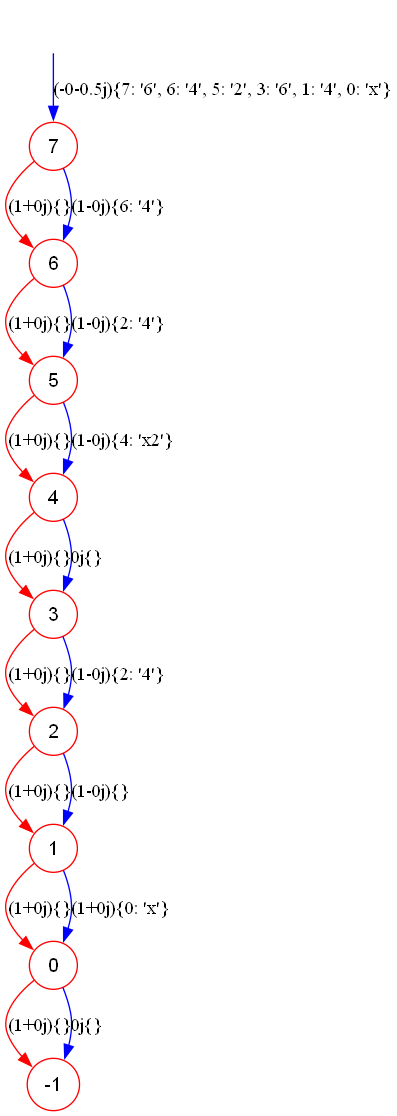

In [15]:
n=4
m=20

cir=gen_cir('Random_Clifford',n,m)
tdd=simulate(cir,True)
tdd.show(False)

Tower
Single
Partial
Entangle


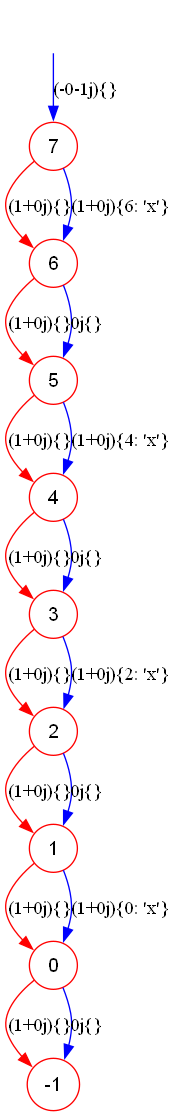

In [16]:
id_tdd,cir_head,cir_end=syn_tower(tdd)
id_tdd.show(False)

In [17]:
tdd_new2=None
flag=True
# for k in range(100):
k=0
while flag:
    print(k)
    k+=1
    if k>1000:
        break
    cir=gen_cir('Random_Clifford_T',n,m)
    tdd2=simulate(cir,False)
    # print(tdd2.node.key,tdd2.node_number())
    if tdd2.node.key!=2*n-1:
        continue
    if tdd2.node_number()>9:
        print('-')
        # break
        
        # continue

    # print(1)
    # tdd_new2,cir_head,cir_end = syn_tower(tdd2)
    tdd_new2,cir_head,cir_end = merge_split(tdd2)
    if tdd_new2.node_number()>9 or tdd_new2.node.key!=2*n-1:
        continue
    if tdd_new2.node!=id_tdd.node or tdd_new2.map.level!=-1:
        flag=False
        print('Find one')
        break
# tdd_new2.show(False)

0
merge
Single
Partial
Entangle
Single
Partial
0 4 9 9
1
merge
Single
Partial
Entangle
Single
Partial
0 4 9 9
2
merge
Single
Partial
Entangle
3
merge
Single
Partial
Entangle
4
-
merge
Single
Partial
Entangle
Single
Partial
6 7 9 9
Entangle
Single
Partial
Single
Partial
4 6 9 9
Entangle
Single
Partial
0 4 9 9
5
merge
Single
Partial
Entangle
6
merge
Single
Partial
Entangle
7
merge
Single
Partial
Entangle
Single
Partial
0 4 9 9
8
merge
Single
Partial
Entangle
Single
Partial
4 7 9 9
Entangle
Single
Partial
0 4 9 9
9
merge
Single
Partial
Entangle
Single
Partial
0 4 9 9
10
merge
Single
Partial
Entangle
Single
Partial
0 4 9 9
11
merge
Single
Partial
Entangle
Single
Partial
Single
Partial
Single
Partial
Single
Partial
Single
Partial
0 7 9 9
12
merge
Single
Partial
Entangle
13
merge
Single
Partial
Entangle
14
merge
Single
Partial
Entangle
Single
Partial
4 7 9 9
Entangle
Single
Partial
0 4 9 9
15
-
merge
Single
Partial
leftmost


NameError: name 'get_leftmost_split_path' is not defined

In [18]:
# cir = QuantumCircuit.from_qasm_file('exp1.qasm')
# cir=QuantumCircuit(2)
# cir.z(0)
# cir.h(1)
# cir.t(0)
# cir.z(1)
# cir.cx(0,1)
# cir.h(0)
# cir.cx(1,0)
# cir.id(1)
# cir.x(0)
# cir.cx(1,0)
cir.draw()
# f=open('exp1.qasm','w')
# f.write(qasm2.dumps(cir))
# f.close()
# cir2=cir

┌───┐┌───┐┌───┐          ┌───┐     ┌───┐┌───┐
q_0: ┤ T ├┤ T ├┤ Z ├───────■──┤ S ├──■──┤ X ├┤ X ├
     ├───┤├───┤├───┤┌───┐  │  ├───┤  │  ├───┤└───┘
q_1: ┤ Y ├┤ Y ├┤ X ├┤ Z ├──┼──┤ T ├──┼──┤ X ├─────
     └───┘└───┘└─┬─┘└───┘┌─┴─┐└───┘┌─┴─┐└───┘     
q_2: ────────────■───────┤ X ├──■──┤ X ├──────────
     ┌───┐┌───┐          └───┘┌─┴─┐├───┤┌───┐┌───┐
q_3: ┤ S ├┤ Z ├───────────────┤ X ├┤ T ├┤ S ├┤ S ├
     └───┘└───┘               └───┘└───┘└───┘└───┘

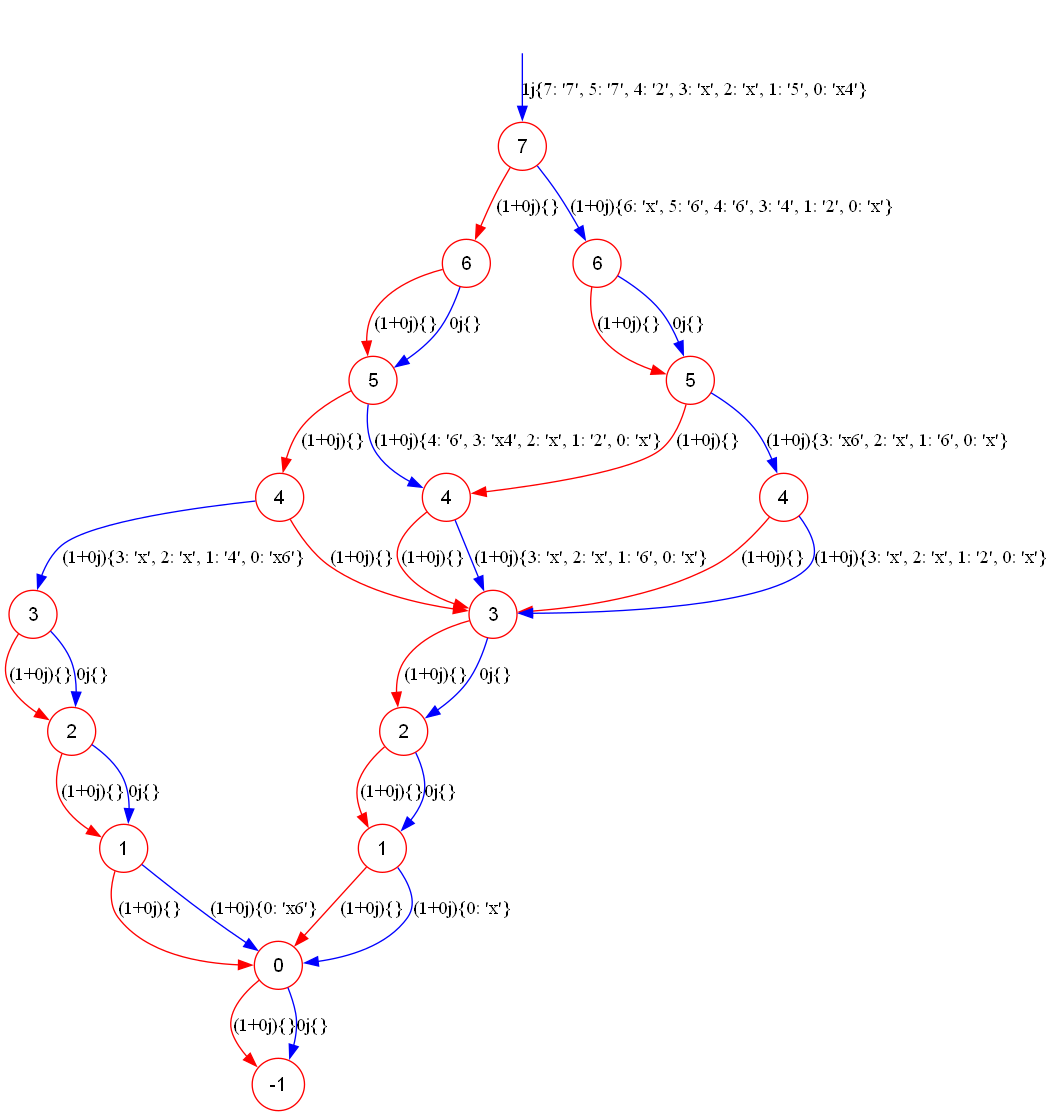

In [19]:
# cir=QuantumCircuit(3)
# cir.cx(0,1)
# cir.ch(0,2)
# cir.id(3)
# cir.cx(1,0)
tdd2=simulate(cir,False)
tdd2.show(False)
# cir.draw()

Single


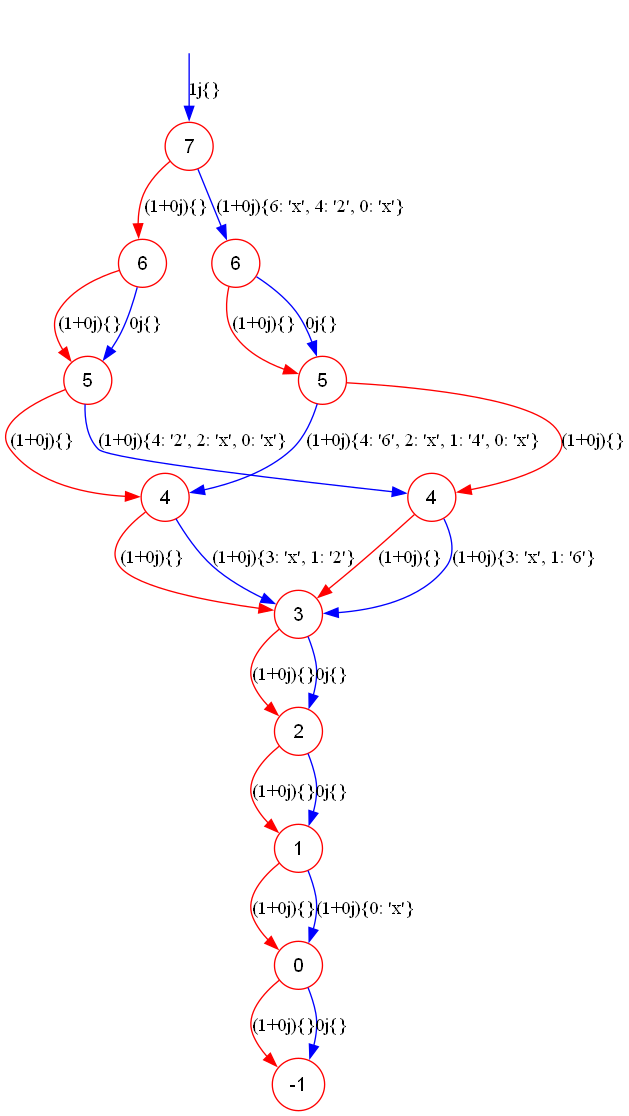

In [20]:
tdd_new,cir_head,cir_end=eliminate_global_map(tdd2)
tdd_new,cir_head,cir_end=eliminate_border_control(tdd_new)
tdd_new,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new)
tdd_new.show(False)

Partial


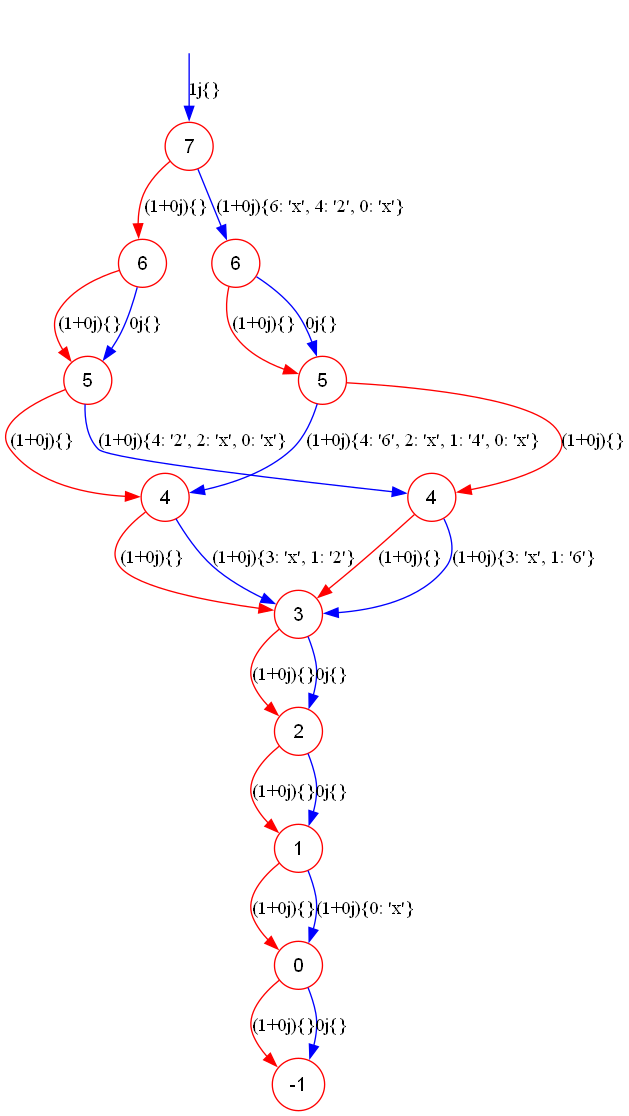

In [21]:
tdd_new,cir_head,cir_end=eliminate_partial_control(tdd_new)
tdd_new.show(False)

In [ ]:
tdd_new,_,_=eliminate_entangel_through_swap(tdd_new,calculated1={})
tdd_new.show(False)

In [ ]:
G = get_dependency_cycle(tdd_new3)
# G=reduce_graph(G)
cycles = list(nx.cycle_basis(G))
# print(cycles)
nx.draw(G,with_labels=True)
print(find_entangel_indices(tdd_new3))
# split_pos = get_leftmost_split_path(tdd_new3)
# print(split_pos)

In [ ]:
tdd_r,cir_head,cir_end = merge_split(tdd_new3)
tdd_r.show(False)
# cir_end.draw()
# tdd2=tdd_r
# # tdd_new.show(False)
# tdd_new3,cir_head,cir_end=test_ch(tdd_new3)
# # tdd_new6,cir_head,cir_end=test_ch(tdd_new6)
# # tdd_new6,_,_ = merge_split(tdd_new6)
# # tdd_new3=tdd_new2.self_copy()
# tdd_new3,cir_head,cir_end=eliminate_global_map(tdd_new3)
# tdd_new3,cir_head,cir_end=eliminate_border_control(tdd_new3)
# tdd_new3,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new3)
# tdd_new3,cir_head,cir_end=eliminate_partial_control(tdd_new3)
# # tdd_new3,_,_=eliminate_entangel_through_swap(tdd_new3,calculated1={})
# tdd_new3.show(False)

[5, 2] -0.7853981633974483
[[ 0.70710678+0.j  0.70710678+0.j]
 [-0.70710678+0.j  0.70710678+0.j]]


C:\Users\23626\AppData\Local\Temp\ipykernel_31280\793073847.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  theta = float(np.arctan((a-b)/(1+a*b)))


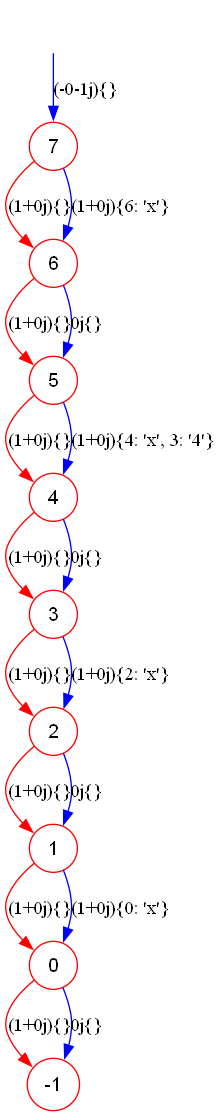

In [51]:
n=4
cir_head2 = QuantumCircuit(n)
cir_end2 = QuantumCircuit(n)

cir_head2.ch(1,2)
# cir_head2.ccz(0,1,2)
# cir_head2.h(3)
# cir_head2.h(1)
# cir_head2.cx(0,1)

# cir_head2.cx(0,1)
# cir_head2.h(3)
# cir_head2.x(1)
# cir_head2.ccz(0,2,3)
# cir_head2.ccz(0,1,3)
# cir_head2.ccz(0,2,3)
# cir_head2.ccz(1,2,3)

 
# cir_end2.h(0)

q0 = 1
q1 = 2
h = 3

if h==0:
    cir_head2.cx(q0,q1)
    cir_head2.cx(q1,q0)
    cir_head2.cx(q0,q1)
if h==1:
    cir_end2.cx(q0,q1)
    cir_end2.cx(q1,q0)
    cir_end2.cx(q0,q1)

# cir_head2.ch(0,2)
# cir_head2.h(2) 

# cir_end2.ch(0,1)
# cir_end2.cx(0,1)
# cir_end2.ccz(0,1,2)
# cir_end2.cx(1,0) 
# cir_end2.h(2)

tdd_new2 = update_tdd(id_tdd,cir_head2,cir_end2)
# tdd_new2,cir_head,cir_end=eliminate_global_map(tdd_new2)
# tdd_new2,cir_head,cir_end=eliminate_border_control(tdd_new2)
# tdd_new2,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new2)
# tdd_new2,cir_head,cir_end=eliminate_partial_control(tdd_new2)
tdd_new2 = renormalize(tdd_new2)
tdd_new2.show(False)
tdd_2,cir_head,cir_end=merge_dif_branch_weight(tdd_new2)
tdd_2.show(False)

In [ ]:
# # from qiskit.quantum_info import Operator
# t=np.arctan(1/np.sqrt(2))
# u_matrix = np.array([[np.cos(t),-np.sin(t)],[np.sin(t),np.cos(t)]])
# print(u_matrix[0][0]/u_matrix[1][0])
# u_gate = QuantumCircuit(1)
# u_gate.unitary(u_matrix, 0)
# cir_head2.append(u_gate.to_gate().control(), [0, 3])
# print(cir_head2)

In [ ]:
n=4
cir_head2 = QuantumCircuit(n)
cir_end2 = QuantumCircuit(n)


cir_head2.ccz(0,1,3)
# cir_head2.cx(0,1)
# cir_head2.ch(0,2)
# cir_head2.h(1)
# cir_head2.ch(2,3)
# cir_head2.ccz(0,1,3)
# cir_head2.ccz(0,1,2)
# cir_head2.ccz(0,2,3)
# cir_head2.ccz(1,2,3)
# cir_end2.h(1)

q0 = 1
q1 = 2
h = 3

if h==0:
    cir_head2.cx(q0,q1)
    cir_head2.cx(q1,q0)
    cir_head2.cx(q0,q1)
if h==1:
    cir_end2.cx(q0,q1)
    cir_end2.cx(q1,q0)
    cir_end2.cx(q0,q1)

# cir_head2.h(0) 

# cir_end2.cz(0,2)
# cir_end2.cs(0,2)
# cir_end2.cx(0,3)
# cir_end2.ccz(1,2,3)
# cir_end2.cx(1,0)
# cir_end2.h(3)
# cir_end2.h(0)
# cir_end2.h(3)

# t=np.arctan(1/np.sqrt(2))
# u_matrix = np.array([[np.cos(t),-np.sin(t)],[np.sin(t),np.cos(t)]])
# u_gate = QuantumCircuit(1)
# u_gate.unitary(u_matrix, 0)
# cir_end2.append(u_gate.to_gate().control(), [0, 1])

tdd_new3 = update_tdd(id_tdd,cir_head2,cir_end2)
tdd_new3,cir_head,cir_end=eliminate_global_map(tdd_new3)
tdd_new3,cir_head,cir_end=eliminate_border_control(tdd_new3)
tdd_new3,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new3)
tdd_new3,cir_head,cir_end=eliminate_partial_control(tdd_new3)
tdd_new3 = renormalize(tdd_new3)
tdd_new3.show(False)
# tdd_2,cir_head,cir_end=merge_split(tdd_new3)
# tdd_2.show(False)

In [ ]:
n=4
cir_head2 = QuantumCircuit(n)
cir_end2 = QuantumCircuit(n)


# cir_head2.ccz(0,1,3)
# cir_head2.cx(0,1)
cir_head2.ch(1,2)
# cir_head2.ch(2,3)

# cir_end2.h(0)
# cir_end2.h(3)
# cir_head2.x(1)
# cir_head2.ccz(0,1,3)
# cir_head2.ccz(0,1,2)
# cir_head2.ccz(0,2,3)
# cir_head2.ccz(1,2,3)
# cir_head2.cz(1,2)
 
# cir_end2.h(0)

q0 = 1
q1 = 2
h = 3

if h==0:
    cir_head2.cx(q0,q1)
    cir_head2.cx(q1,q0)
    cir_head2.cx(q0,q1)
if h==1:
    cir_end2.cx(q0,q1)
    cir_end2.cx(q1,q0)
    cir_end2.cx(q0,q1)

# cir_head2.h(2) 

# cir_end2.ch(0,1)
# cir_end2.cz(0,1)
# cir_end2.ccz(0,1,2)
# cir_end2.ccz(1,2,3)
# cir_end2.cx(1,0)
# cir_end2.h(1)
# cir_end2.h(0)
# cir_end2.h(2)

tdd_new4 = update_tdd(tdd_new3,cir_head2,cir_end2)
# tdd_new4,cir_head,cir_end=eliminate_global_map(tdd_new4)
# tdd_new4,cir_head,cir_end=eliminate_border_control(tdd_new4)
# tdd_new4,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new4)
# tdd_new4,cir_head,cir_end=eliminate_partial_control(tdd_new4)
# tdd_new4 = renormalize(tdd_new4)
tdd_new4.show(False)
# tdd_2,cir_head,cir_end=merge_split(tdd_new4)
# tdd_2.show(False)

In [ ]:
n=4
cir_head2 = QuantumCircuit(n)
cir_end2 = QuantumCircuit(n)


# cir_head2.ccz(0,1,2)
# cir_head2.cx(0,1)
# cir_head2.h(1)
# cir_head2.h(0)

# cir_end2.h(1)
# cir_head2.x(1)
# cir_head2.ccz(0,1,3)
# cir_head2.ccz(0,1,2)
# cir_head2.ccz(0,2,3)
# cir_head2.ccz(1,2,3)
# cir_head2.cz(1,2)
 
# cir_end2.h(0)

q0 = 1
q1 = 3
h = 2

if h==0:
    cir_head2.cx(q0,q1)
    cir_head2.cx(q1,q0)
    cir_head2.cx(q0,q1)
if h==1:
    cir_end2.cx(q0,q1)
    cir_end2.cx(q1,q0)
    cir_end2.cx(q0,q1)

# cir_head2.h(2) 

cir_end2.ch(0,2)
# cir_end2.cx(0,3)
# cir_end2.ccz(0,2,3)
# cir_end2.cx(1,0)
# cir_end2.h(1)
# cir_end2.h(0)
# cir_end2.h(2)

tdd_new5 = update_tdd(tdd_new4,cir_head2,cir_end2)
tdd_new5,cir_head,cir_end=eliminate_global_map(tdd_new5)
tdd_new5,cir_head,cir_end=eliminate_border_control(tdd_new5)
tdd_new5,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new5)
tdd_new5,cir_head,cir_end=eliminate_partial_control(tdd_new5)
tdd_new5 = renormalize(tdd_new5)
tdd_new5.show(False)
# tdd_2,cir_head,cir_end=merge_split(tdd_new4)
# tdd_2.show(False)

In [ ]:
n=4
cir_head2 = QuantumCircuit(n)
cir_end2 = QuantumCircuit(n)


# cir_head2.ccz(0,1,2)
# cir_head2.cx(0,1)
# cir_head2.h(1)
# cir_head2.h(0)

# cir_end2.h(1)
# cir_head2.x(1)
# cir_head2.ccz(0,1,3)
# cir_head2.ccz(0,1,2)
# cir_head2.ccz(0,2,3)
# cir_head2.ccz(0,2,3)
# cir_head2.cz(1,2)
 
# cir_end2.h(0)

q0 = 2
q1 = 3
h = 1

if h==0:
    cir_head2.cx(q0,q1)
    cir_head2.cx(q1,q0)
    cir_head2.cx(q0,q1)
if h==1:
    cir_end2.cx(q0,q1)
    cir_end2.cx(q1,q0)
    cir_end2.cx(q0,q1)

# cir_head2.h(2) 

# cir_end2.ch(0,1)
# cir_end2.cx(0,3)
# cir_end2.ccz(1,2,3)
# cir_end2.cx(1,0)
# cir_end2.h(1)
# cir_end2.h(0)
# cir_end2.h(2)

tdd_new6 = update_tdd(tdd_new5,cir_head2,cir_end2)
tdd_new6,cir_head,cir_end=eliminate_global_map(tdd_new6)
tdd_new6,cir_head,cir_end=eliminate_border_control(tdd_new6)
tdd_new6,cir_head,cir_end=eliminate_sigle_qubit_gates(tdd_new6)
tdd_new6,cir_head,cir_end=eliminate_partial_control(tdd_new6)
tdd_new6 = renormalize(tdd_new6)
tdd_new6.show(False)
# tdd_2,cir_head,cir_end=merge_split(tdd_new4)
# tdd_2.show(False)


In [ ]:
tttt,_,_=merge_multi_control(tdd_new3)
tttt.show(False)